# SETI CNN using TF and Binary DS

In [61]:
import requests
import json
#import ibmseti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import time
#!sudo pip install sklearn
import os
from sklearn.metrics import confusion_matrix

### import dataset reader

In [62]:
!wget --output-document SETI.zip  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
!unzip -o SETI.zip
import SETI

--2017-05-23 10:36:21--  https://ibm.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.box.com (ibm.box.com)... 107.152.27.197
Connecting to ibm.box.com (ibm.box.com)|107.152.27.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip [following]
--2017-05-23 10:36:21--  https://ibm.ent.box.com/shared/static/jhqdhcblhua5dx2t7ixwm88okitjrl6l.zip
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.26.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.26.211|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/FmYe_3GFC7xCDGC23-wKgQTDBOUbtjXZw4r45J-k-e8DuE2Q94cBdjztssMU_jTByyj1BJZMPdgaZU9C7QZMz3UZr3B_S8vQ9G2t9onA5hpoTpIeOBsarx4UQALhaTHFQaiMF1gibZNOd3QT7B4o_cCdYdVG9Wg6akDVUEAbDYvDsY9MrezVnWVAlVb3RSuH-RgqqM1cuphYNo8KePDYn4gA25t2wzKJTIL1WMpdPRJOf5xFGPpHBB9rLh4Fz4hjk0WQNb1krwDd039Vu8riOzE-m

### Download data

In [63]:
ds_directory = 'SETI/SETI_ds_64x128/'
ds_name = 'SETI/SETI64x128.tar.gz'

In [64]:
print os.popen("ls -lrt "+ ds_directory).read() # to verify

total 7152
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users 1665328 May 22 21:11 train-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users     306 May 22 21:11 train-labels-idx1-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users  765379 May 22 21:11 test-images-idx3-ubyte.gz
-rw-r----- 1 sd22-2e55b7df66e8c3-b01c69100280 users     172 May 22 21:11 test-labels-idx1-ubyte.gz



### Load data SETI

In [65]:
# from tensorflow.examples.tutorials.mnist import input_data
#dataset = input_data.read_data_sets("MNIST_data/", one_hot=True)
dataset = SETI.read_data_sets(ds_directory, one_hot=True, validation_size=0)
dataset.train.images.shape

Extracting SETI/SETI_ds_64x128/train-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_64x128/train-labels-idx1-ubyte.gz
Extracting SETI/SETI_ds_64x128/test-images-idx3-ubyte.gz
Extracting SETI/SETI_ds_64x128/test-labels-idx1-ubyte.gz


(694, 8192)

## Network Parameters

In [66]:
# Parameters
learning_rate = 0.00001
training_epochs = 3
batch_size = 15
display_step = 10

#check point directory
chk_directory = 'SETI/save/'
checkpoint_path = chk_directory+'model.ckpt'


n_classes = 4 # number of possible classifications for the problem
dropout = 0.75 # Dropout, probability to keep units

height = 64 # height of the image in pixels 
width = 128 # width of the image in pixels 
n_input = width * height # number of pixels in one image 


### Inputs

In [67]:
x  = tf.placeholder(tf.float32, shape=[None, n_input])
y_ = tf.placeholder(tf.float32, shape=[None, n_classes])

In [68]:
x_image = tf.reshape(x, [-1,height,width,1]) 
x_image

<tf.Tensor 'Reshape_10:0' shape=(?, 64, 128, 1) dtype=float32>

#### Convolutional Layer 1

In [69]:
W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs
convolve1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
h_conv1 = tf.nn.relu(convolve1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
layer1= h_pool1
layer1

<tf.Tensor 'MaxPool_7:0' shape=(?, 32, 64, 32) dtype=float32>

#### Convolutional Layer 2

In [70]:
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs
convolve2= tf.nn.conv2d(layer1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
h_conv2 = tf.nn.relu(convolve2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
layer2= h_pool2
layer2

<tf.Tensor 'MaxPool_8:0' shape=(?, 16, 32, 64) dtype=float32>

#### Convolutional Layer 3

In [71]:
W_conv3 = tf.Variable(tf.truncated_normal([5, 5, 64, 128], stddev=0.1))
b_conv3 = tf.Variable(tf.constant(0.1, shape=[128])) #need 64 biases for 64 outputs
convolve3= tf.nn.conv2d(layer2, W_conv3, strides=[1, 1, 1, 1], padding='SAME')+ b_conv3
h_conv3 = tf.nn.relu(convolve3)
h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
layer3= h_pool3
layer3

<tf.Tensor 'MaxPool_9:0' shape=(?, 8, 16, 128) dtype=float32>

#### Convolutional Layer 4

In [72]:
W_conv4 = tf.Variable(tf.truncated_normal([5, 5, 128, 256], stddev=0.1))
b_conv4 = tf.Variable(tf.constant(0.1, shape=[256])) #need 64 biases for 64 outputs
convolve4= tf.nn.conv2d(layer3, W_conv4, strides=[1, 1, 1, 1], padding='SAME')+ b_conv4
h_conv4 = tf.nn.relu(convolve4)
h_pool4 = tf.nn.max_pool(h_conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME') #max_pool_2x2
layer4= h_pool4
layer4

<tf.Tensor 'MaxPool_10:0' shape=(?, 4, 8, 256) dtype=float32>

#### Fully Connected Layer 1

In [73]:
input_layer = layer3
dim = input_layer.get_shape().as_list()
dim

[None, 8, 16, 128]

In [74]:
dims= dim[1]*dim[2]*dim[3]
nodes1 = 1024
prv_layer_matrix = tf.reshape(input_layer, [-1, dims])
W_fc1 = tf.Variable(tf.truncated_normal([dims, nodes1], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[nodes1])) # need 1024 biases for 1024 outputs
fcl1  = tf.matmul(prv_layer_matrix, W_fc1) + b_fc1
h_fc1 = tf.nn.relu(fcl1) # ???
h_fc1


<tf.Tensor 'Relu_14:0' shape=(?, 1024) dtype=float32>

#### Fully Connected Layer 2

In [75]:
nodes2 = 256
W_fc2 = tf.Variable(tf.truncated_normal([h_fc1.get_shape().as_list()[1], nodes2], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[nodes2])) 
fcl2  = tf.matmul(h_fc1, W_fc2) + b_fc2
h_fc2 = tf.nn.relu(fcl2) # ???
h_fc2

<tf.Tensor 'Relu_15:0' shape=(?, 256) dtype=float32>

#### Droupout

In [76]:
keep_prob = tf.placeholder(tf.float32)
layer_drop = tf.nn.dropout(h_fc1, keep_prob)

#### Softmax Layer

In [77]:
W_fc = tf.Variable(tf.truncated_normal([nodes1, n_classes], stddev=0.1)) #1024 neurons
b_fc = tf.Variable(tf.constant(0.1, shape=[n_classes])) # 10 possibilities for classes [0,1,2,3]
fc = tf.matmul(layer_drop, W_fc) + b_fc
y_CNN= tf.nn.softmax(fc)

#### Training


In [78]:
#cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_l4_conv), reduction_indices=[1]))
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_CNN, labels=y_))
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

#### Evaluation

In [79]:
correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Creatte checkpoint directory

In [80]:
directory = os.path.dirname(chk_directory)
try:
    os.stat(directory)
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    print ckpt
except:
    os.mkdir(directory) 

model_checkpoint_path: "SETI/save/model.ckpt-2"
all_model_checkpoint_paths: "SETI/save/model.ckpt-0"
all_model_checkpoint_paths: "SETI/save/model.ckpt-1"
all_model_checkpoint_paths: "SETI/save/model.ckpt-2"



## Training

In [81]:
# Initializing the variables
init = tf.initialize_all_variables()

In [82]:
# Launch the graph
with tf.Session() as sess:

    
    X_test = dataset.test.images
    y_test = dataset.test.labels
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        #saver.restore(sess, ckpt.model_checkpoint_path)
    
    
    #step = 0
    num_examples = dataset.train.num_examples
    # Training cycle
    for epoch in range(training_epochs):
        avg_loss = 0.
        avg_accuracy = 0.
        #dataset.shuffle_data()
        total_batch = int(num_examples / batch_size)
        # print total_batch
        # Loop over all batches
        for step in range(total_batch):
            start = time.time()
            x_batch, y_batch = dataset.train.next_batch(batch_size, shuffle=True)
            train_step.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: dropout})
            loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
            #assert( loss < 1000000 ) # make sure it is not NaN or Inf
            #assert( accuracy < 1000000 ) # make sure it is not NaN or Inf
            
            end = time.time()
            
            avg_loss += loss / total_batch
            
            if step % display_step == 0:

                
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cross_entropy, accuracy], feed_dict={x: x_batch,y_: y_batch,keep_prob: 1.})
                #train_accuracy = accuracy.eval(feed_dict={x:x_batch, y_: y_batch,  keep_prob: 0.5})

                test_accuracy = sess.run(accuracy, feed_dict={x: X_test[0:60], y_: y_test[0:60], keep_prob: 1.})

                print("Iter " + str(step) + \
                    ", Training time= " + "{:.5f}".format(end - start) + \
                    ", Minibatch Loss= " +  "{:.6f}".format(loss) +  \
                    ", Training Accuracy= " + "{:.5f}".format(acc)  + \
                    ", Test Accuracy= " + "{:.5f}".format(test_accuracy) )
        
        # save model every 1 epochs
        if epoch >= 0 and epoch % 1 == 0:
            # Save model
            print ("model saved to {}".format(checkpoint_path))
            saver.save(sess, checkpoint_path, global_step = epoch)

            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_loss) 

    print("Optimization Finished!")

    
    
    # Calculate accuracy for test images
    #print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: X_test[0:30], y_: y_test[0:30], keep_prob: 1.}))
        
    # Find the labels of test set
    y = sess.run(tf.argmax(y_CNN,1), feed_dict={x: X_test[0:100], y_: y_test[0:100], keep_prob: 1.})
    
    # lets save kernels
    kernels_l1 = sess.run(tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0, 1]),[32,-1]))
    kernels_l2 = sess.run(tf.reshape(tf.transpose(W_conv2, perm=[2, 3, 0, 1]),[32*64,-1]))

loading model:  SETI/save/model.ckpt-2
Iter 0, Training time= 0.63649, Minibatch Loss= 1.477002, Training Accuracy= 0.26667, Test Accuracy= 0.21667
Iter 10, Training time= 0.23844, Minibatch Loss= 1.543668, Training Accuracy= 0.20000, Test Accuracy= 0.21667
Iter 20, Training time= 0.22207, Minibatch Loss= 1.473397, Training Accuracy= 0.26667, Test Accuracy= 0.21667
Iter 30, Training time= 0.23843, Minibatch Loss= 1.342323, Training Accuracy= 0.40000, Test Accuracy= 0.45000
Iter 40, Training time= 0.22254, Minibatch Loss= 1.411042, Training Accuracy= 0.33333, Test Accuracy= 0.45000
model saved to SETI/save/model.ckpt
Epoch: 0001 cost= 1.399120136
Iter 0, Training time= 0.27293, Minibatch Loss= 1.477124, Training Accuracy= 0.26667, Test Accuracy= 0.45000
Iter 10, Training time= 0.20245, Minibatch Loss= 1.210535, Training Accuracy= 0.53333, Test Accuracy= 0.45000
Iter 20, Training time= 0.23807, Minibatch Loss= 1.410322, Training Accuracy= 0.33333, Test Accuracy= 0.45000
Iter 30, Training

## Evaluation

In [83]:
y_ = np.argmax(y_test[0:100],1)
confusion_matrix(y_, y)

array([[25,  0,  0,  0],
       [28,  0,  0,  0],
       [23,  0,  0,  0],
       [ 0,  0,  0, 24]])

### Viz

In [84]:
!wget --output-document utils1.py http://deeplearning.net/tutorial/code/utils.py
import utils1
from utils1 import tile_raster_images

--2017-05-23 10:37:16--  http://deeplearning.net/tutorial/code/utils.py
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/plain]
Saving to: ‘utils1.py’

100%[======================================>] 5,097       --.-K/s   in 0s      

2017-05-23 10:37:16 (626 MB/s) - ‘utils1.py’ saved [5097/5097]



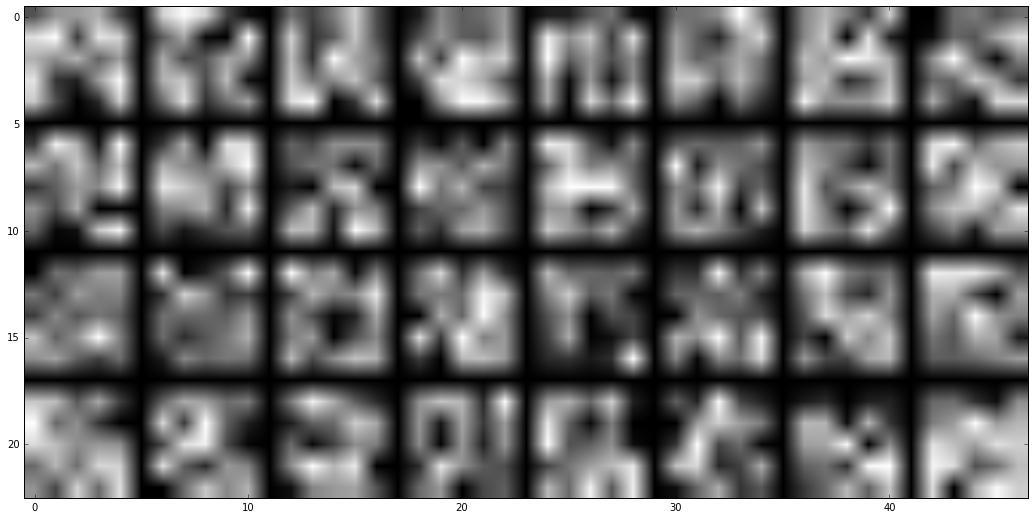

In [85]:
#from utils import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels_l1, img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

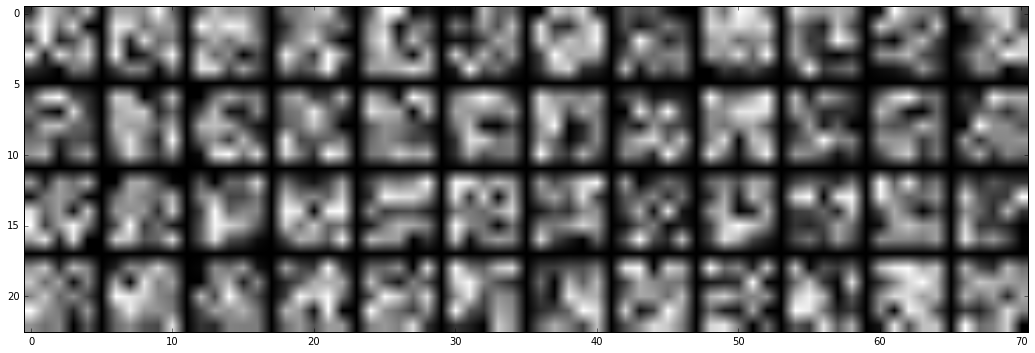

In [86]:
image = Image.fromarray(tile_raster_images(kernels_l2, img_shape=(5, 5) ,tile_shape=(4, 12), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

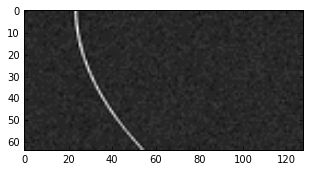

In [87]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage1 = X_test[3]
plt.imshow(np.reshape(sampleimage1,[64,128]), cmap="gray")

loading model:  SETI/save/model.ckpt-2


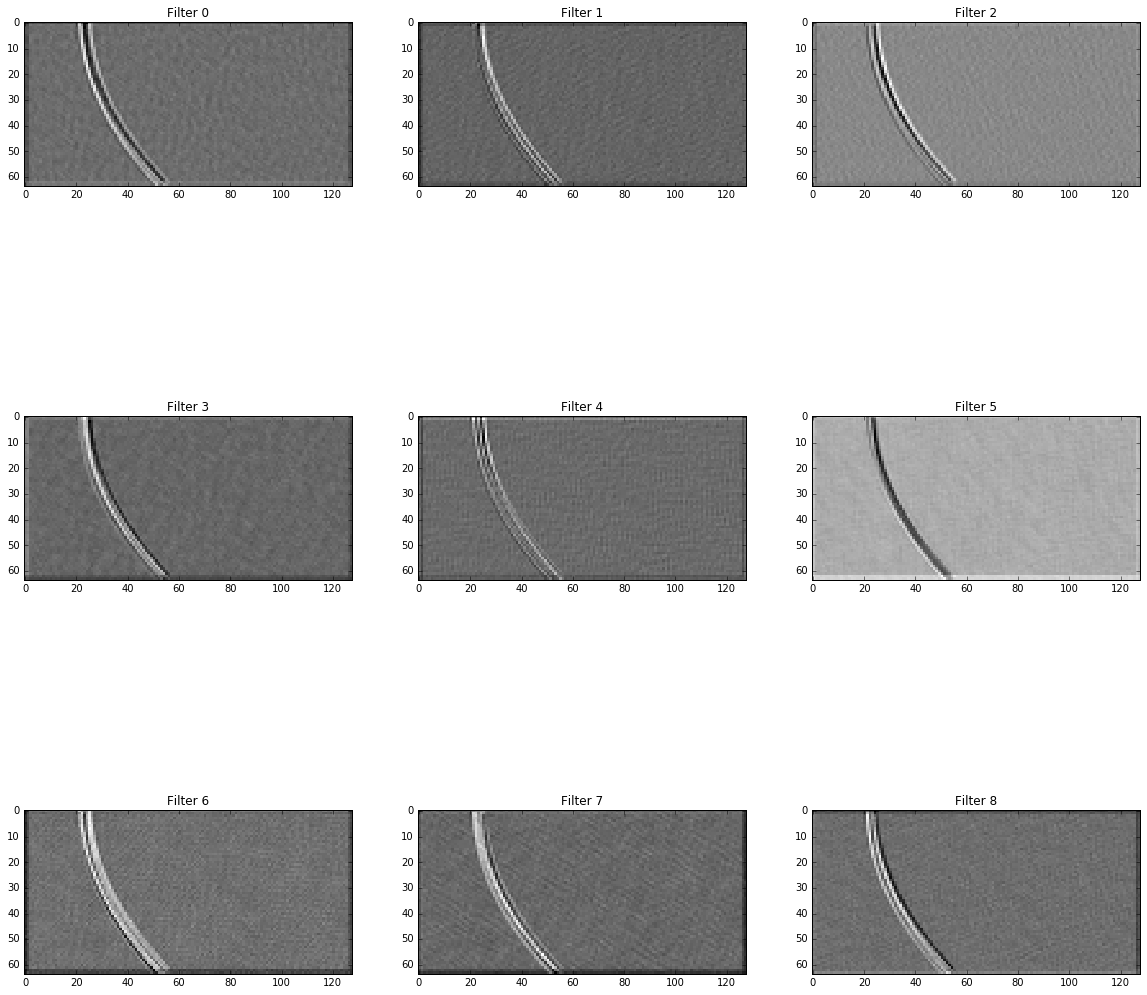

In [88]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    saver = tf.train.Saver(tf.all_variables())
    
    # load previously trained model if appilcable
    ckpt = tf.train.get_checkpoint_state(chk_directory)
    if ckpt:
        print "loading model: ",ckpt.model_checkpoint_path
        saver.restore(sess, ckpt.model_checkpoint_path)
    ActivatedUnits1 = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage1,[1,64*128],order='F'),keep_prob:1.0})
    plt.figure(1, figsize=(20,20))
    n_columns = 3
    n_rows = 3
    for i in range(9):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(ActivatedUnits1[0,:,:,i], interpolation="nearest", cmap="gray")